In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [15]:
## 1. Data Preprocessing and Model Building
# Set random seed for reproducibility
np.random.seed(42)

In [16]:
## 2. Load the Dataset
# Load the data
loan_data = pd.read_csv('loan_data.csv')

# Display basic info
print("Dataset shape:", loan_data.shape)
print("\nFirst few rows:")
loan_data.head()

Dataset shape: (307511, 122)

First few rows:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
## 3. Check for Null Values
# Check for null values
null_values = loan_data.isnull().sum()
null_percentage = (loan_data.isnull().sum() / len(loan_data)) * 100

print("Null values in dataset:")
pd.DataFrame({'Null Count': null_values, 'Percentage': null_percentage}).sort_values(by='Percentage', ascending=False).head(20)

Null values in dataset:


,Null Count,Percentage
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


Percentage of defaults (TARGET=1): 8.07%


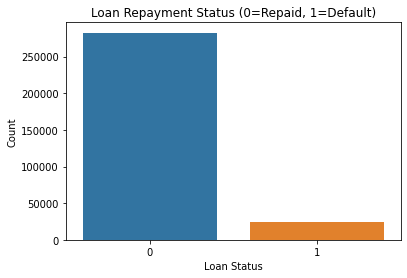

In [18]:
## 4. Percentage of Defaults
# Calculate default rate
default_rate = loan_data['TARGET'].mean()
print(f"Percentage of defaults (TARGET=1): {default_rate*100:.2f}%")

# Plot the target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='TARGET', data=loan_data)
plt.title('Loan Repayment Status (0=Repaid, 1=Default)')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

In [19]:
## 5. Balance the Dataset
# Check for null values and calculate the percentage of default (TARGET = 1)
null_values = loan_data.isnull().sum().sort_values(ascending=False)
default_percentage = loan_data['TARGET'].value_counts(normalize=True) * 100

null_values.head(10), default_percentage

# Drop ID column and rows with null values for simplicity at this stage
loan_data_cleaned = loan_data.drop(columns=['SK_ID_CURR']).dropna()

# Split features and target
X = loan_data_cleaned.drop(columns=['TARGET'])
y = loan_data_cleaned['TARGET']

# Encode categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Perform SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Return the class distribution after SMOTE
y_resampled.value_counts()
print(f"Resampled dataset shape: {X_resampled.shape}")

Resampled dataset shape: (16152, 120)


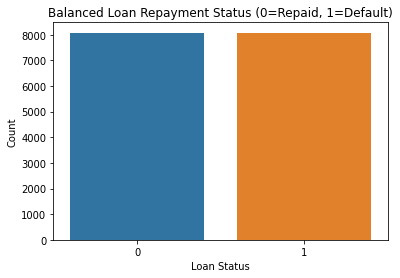

In [20]:
## 6. Plot the Balanced Data
# Plot the balanced data
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled)
plt.title('Balanced Loan Repayment Status (0=Repaid, 1=Default)')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

In [21]:
## 7. Train-Test Split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Convert to categorical for neural network
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [22]:
## 8. Build Deep Learning Model
# Get input dimension
input_dim = X_train.shape[1]

# Build the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1)

Epoch 1/50
162/162 [==============================] - 2s 3ms/step - loss: 0.8602 - accuracy: 0.5256 - val_loss: 0.6863 - val_accuracy: 0.5578
Epoch 2/50
162/162 [==============================] - 0s 2ms/step - loss: 0.7387 - accuracy: 0.5422 - val_loss: 0.6853 - val_accuracy: 0.5373
Epoch 3/50
162/162 [==============================] - 0s 2ms/step - loss: 0.7130 - accuracy: 0.5441 - val_loss: 0.6841 - val_accuracy: 0.5431
Epoch 4/50
162/162 [==============================] - 0s 2ms/step - loss: 0.6919 - accuracy: 0.5550 - val_loss: 0.6794 - val_accuracy: 0.5632
Epoch 5/50
162/162 [==============================] - 0s 2ms/step - loss: 0.6861 - accuracy: 0.5592 - val_loss: 0.6794 - val_accuracy: 0.5578
Epoch 6/50
162/162 [==============================] - 0s 2ms/step - loss: 0.6814 - accuracy: 0.5664 - val_loss: 0.6818 - val_accuracy: 0.5524
Epoch 7/50
162/162 [==============================] - 0s 2ms/step - loss: 0.6805 - accuracy: 0.5616 - val_loss: 0.6788 - val_accuracy: 0.5613
Epoch 

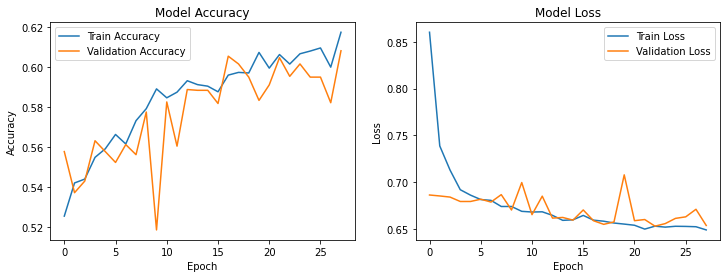

Test Accuracy: 0.5995
101/101 [==============================] - 0s 795us/step
Sensitivity (Recall): 0.7102
ROC AUC Score: 0.6580


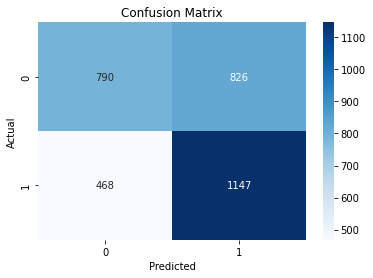

In [23]:
## 9. Model Evaluation
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict probabilities
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate Sensitivity (Recall)
sensitivity = recall_score(y_test, y_pred)
print(f"Sensitivity (Recall): {sensitivity:.4f}")

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()